In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [2]:
biological_data = pd.read_csv("biological_data.csv").drop('Unnamed: 0', axis=1)
biological_data

,Y,X1,X2,X3,X4,X5,X6
0,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,82.277778,106.555556,-4.522222e+01
1,138,human,XSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01
2,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01
3,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,85.444444,108.888889,-9.666667e+00
4,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,50.611111,85.444444,1.233581e-15
...,...,...,...,...,...,...,...
1990,761,human,XSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGE...,XSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAA...,82.000000,106.000000,-2.060000e+01
1991,1215,human,XSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAA...,82.000000,106.000000,-2.060000e+01
1992,2238,human,XSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGE...,XSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,85.950000,112.600000,-1.800000e+00
1993,1981,human,XSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGE...,XSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,83.650000,110.800000,-8.700000e+00


In [3]:
# Preprocessing of data with k-mer analysis

# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

human_data = biological_data.copy()
human_data['X2'] = human_data.apply(lambda x: getKmers(x['X2']), axis=1)
human_data['X3'] = human_data.apply(lambda x: getKmers(x['X3']), axis=1)

human_data_X2 = list(human_data['X2'])
human_data_X3 = list(human_data['X3'])
for item in range(len(human_data)):
    human_data_X2[item] = ' '.join(human_data_X2[item])
    human_data_X3[item] = ' '.join(human_data_X3[item])

y_data = human_data.iloc[:, 0].values 

In [4]:
human_data_X3

['xshtlq shtlqr htlqrm tlqrmf lqrmfg qrmfgc rmfgcd mfgcdl fgcdlg gcdlgp cdlgpd dlgpdg lgpdgr gpdgrl pdgrll dgrllr grllrg rllrgy llrgyn lrgynq rgynqf gynqfa ynqfay nqfayd qfaydg faydgk aydgkd ydgkdy dgkdyi gkdyia kdyial dyialn yialne ialned alnedl lnedlr nedlrs edlrsw dlrswt lrswta rswtaa swtaad wtaadt taadta aadtaa adtaaq dtaaqi taaqit aaqitq aqitqr qitqrk itqrkw tqrkwe qrkwea rkweaa kweaar weaare eaarea aareae areaeq reaeqr eaeqrr aeqrra eqrray qrrayl rrayle rayleg aylegt ylegtc legtcv egtcve gtcvew tcvewl cvewlr vewlrr ewlrry wlrryl lrryle rrylen ryleng ylengk lengke engket ngketl gketlq ketlqr etlqra',
 'xshtlq shtlqw htlqwm tlqwmf lqwmfg qwmfgc wmfgcd mfgcdl fgcdlg gcdlgp cdlgpd dlgpdg lgpdgr gpdgrl pdgrll dgrllr grllrg rllrgy llrgyd lrgydq rgydqs gydqsa ydqsay dqsayd qsaydg saydgk aydgkd ydgkdy dgkdyi gkdyia kdyial dyialn yialne ialned alnedl lnedlr nedlrs edlrsw dlrswt lrswta rswtaa swtaad wtaadt taadta aadtaa adtaaq dtaaqi taaqit aaqitq aqitqr qitqrk itqrkw tqrkwe qrkwea rkweaa 

In [5]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
cv = CountVectorizer(ngram_range=(4,4))
X2 = cv.fit_transform(human_data_X2)
X3 = cv.fit_transform(human_data_X3)

In [6]:
# Concat X2 and X3 [X2,X3]
X2X3 = np.concatenate((X2.toarray(), X3.toarray()), axis=1)

In [7]:
X2X3

array([[1, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1]])

In [8]:
# Splitting the human dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X2X3, y_data, test_size = 0.20, random_state=42)

Epoch 1/100


2023-01-15 13:15:58.289442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 13:15:58.293794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 13:15:58.294472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 13:15:58.295355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

 1/25 [>.............................] - ETA: 21s - loss: 110010328.0000 - accuracy: 0.0156

2023-01-15 13:15:59.994847: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 1s 9ms/step - loss: 98365864.0000 - accuracy: 0.0702 - val_loss: 98236280.0000 - val_accuracy: 0.0727
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 97949072.0000 - accuracy: 0.0802 - val_loss: 97530656.0000 - val_accuracy: 0.0727
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 96848000.0000 - accuracy: 0.0815 - val_loss: 95900848.0000 - val_accuracy: 0.0727
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 94507632.0000 - accuracy: 0.0815 - val_loss: 92772808.0000 - val_accuracy: 0.0727
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 90540592.0000 - accuracy: 0.0815 - val_loss: 87877584.0000 - val_accuracy: 0.0727
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 85457408.0000 - accuracy: 0.0815 - val_loss: 81889952.0000 - val_accuracy: 0.0727
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 78817016.

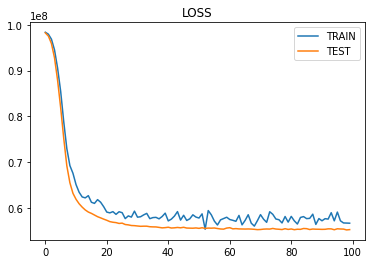

In [9]:
# DNN Regression (X2X3, K-mer (N-gram)) 
input_dim = X_train.shape[1]
DNNmodel = Sequential()
DNNmodel.add(Dense(100, input_dim=input_dim, activation='relu'))
DNNmodel.add(Dropout(0.5))
DNNmodel.add(Dense(20, activation='relu'))
DNNmodel.add(Dropout(0.5))
DNNmodel.add(Dense(1))

DNNmodel.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = DNNmodel.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("LOSS")
plt.legend(["TRAIN" , "TEST"])
plt.show()

13/13 [==============================] - 0s 1ms/step


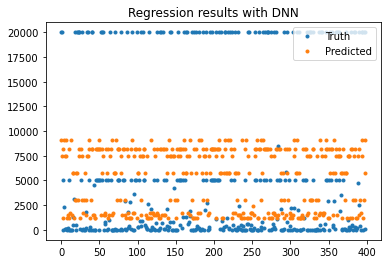

In [32]:
y_pred = DNNmodel.predict(X_test)
x = np.arange(399)
plt.figure()
plt.plot(x,y_test, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with DNN")
plt.show()